# Project Introduction - Customer Segmentation (Part 3)
The goal of this project is to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population with the aim of understanding which segment of the population the company should aim for in its next mail campaign. 

The project is divided into __three main parts__:
1. The first part will be decicated to the __data preparation__: This data is high-dimensional and has a high degree of missing values, therefore it is important to understand and clean the data.
2. In this section the customers will be segmented using a __unsupervised learning approach__ and using the customer's data against the general population's data. Not only is the goal to understand which groups of customers are more interesting for the campaign but also to select the most important features.
3. Using the information gained a __supervised learning algorithm__ will be used for a classification task to predict which recipients are most likely to become a customer for the mail-order company.

__Note__: This notebook only handles part 3.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, make_scorer, get_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score, matthews_corrcoef
from joblib import dump, load

# magic word for producing visualizations in notebook
%matplotlib inline

# configurations
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)

# PART 3: Customer Prediction (Supervised Learning)
In this section we will use different models to train a model that predicts whether a given individual is going to be a customer or not. We will use the Mailout dataset which includes the target variable to build and test the model and at the end we will use the second dataset without the target variable to see how many individuals our customers would likely be.

The approach looks like this:
1.	Brief exploratory data analysis of the distributions of the target variable.
2.  Build a ml pipeline to try different models and different data strategies.
4.  Hyperparameter tuning for the chosen best model.
5.  Refit the best model onto the whole dataset.
6.  Predict on the new data (data without the target variable).
7.  Finalize with an analysis of the results.

In [2]:
# Load the cleaned data for the customer segmentation part
train_df = pd.read_csv('data\\Cleaned_Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test_df = pd.read_csv('data\\Cleaned_Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [3]:
train_df.shape

(34508, 509)

In [4]:
test_df.shape

(34499, 508)

# 1. Target Variable Analysis

Percentage of 0s: 98.7%
Percentage of 1s: 1.3%


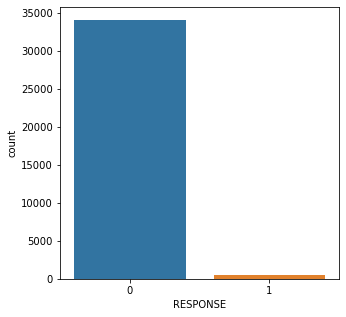

In [5]:
# Plot the counts for the reponse variable
plt.figure(figsize = (5, 5))
sns.countplot(data = train_df, x='RESPONSE')

print(f"Percentage of 0s: {round((len(train_df[train_df['RESPONSE'] == 0]) / len(train_df['RESPONSE']))*100, 1)}%")
print(f"Percentage of 1s: {round((len(train_df[train_df['RESPONSE'] == 1]) / len(train_df['RESPONSE']))*100, 1)}%")

__Observation__: This dataset is extremely imbalanced. There are several ways to try and tackle this problem like undersampling the label 0 or oversampling the label 1. Between both, oversampling the label 1 would be preferable since we are not losing any information with this.

In this case I will try to overcome this problem by applying more weight to the 1 class during model training and try to use a stratified cross-validation approach, which can be beneficial when dealing with imbalanced classes when comparing to the standard approach. This is one strategy for dealing with the data that I will use to compare to other approaches and see if it improves the performance.

# 2. Build the ML Pipeline

In [6]:
def plot_learning_curve(estimator, X, y, scorer, oversampling=False, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    This function is used to plot the learning curve for a desired estimator based on a specified metric.
    
    PARAMETERS:
    -----------
        estimator (sklearn estimator): Your estimator of choice.
        X (DataFrame): The features of your dataset.
        y (DataFrame): The target variable of your dataset.
        scorer (string): The scorer to be used as metric for the learning curve.
        oversampling (bool): If True, use SMOTE to oversample during each CV split.
        cv (integer): A number for the cross-validation steps.
        n_jobs (integer): How to run the jobs (parallel = -1, sequential = 1/None)
        train_sizes (numpy.ndarray): An array to check for different sizes of the training data.
    """
    model_name = estimator.__class__.__name__
    scorer_name = "-".join(scorer.upper().split("_"))
       
    if oversampling:
        scorer = get_scorer(scorer)
        train_scores = []
        test_scores = []
        train_sizes_list = []

        for frac in train_sizes:
            cv_scores_train = []
            cv_scores_test = []
            skf = StratifiedKFold(n_splits=cv)
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                # Subset data to match the desired fraction
                subset_size = int(frac * len(X_train))
                X_train_subset = X_train[:subset_size]
                y_train_subset = y_train[:subset_size]

                # Apply SMOTE only on the training data
                smote = SMOTETomek()
                X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_subset, y_train_subset)

                estimator.fit(X_train_oversampled, y_train_oversampled)
                cv_scores_train.append(scorer(estimator, X_train_oversampled, y_train_oversampled))
                cv_scores_test.append(scorer(estimator, X_test, y_test))

            train_scores.append(cv_scores_train)
            test_scores.append(cv_scores_test)
            train_sizes_list.append(subset_size)
        train_percentages = np.array(train_sizes_list) / len(X) * 100
    else:
        train_sizes, train_scores, test_scores = learning_curve(estimator, 
                                                                X, 
                                                                y, 
                                                                cv=cv, 
                                                                n_jobs=n_jobs, 
                                                                train_sizes=train_sizes, 
                                                                scoring=scorer)
        train_percentages = train_sizes / len(X) * 100

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    overall_train_scores_mean = np.mean(train_scores_mean)
    overall_test_scores_mean = np.mean(test_scores_mean)
 
    plt.figure(figsize=(10, 7))
    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Percentage of Training Set")
    plt.ylabel(f"{scorer_name} Score")
 
    plt.fill_between(train_percentages, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_percentages, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_percentages, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_percentages, test_scores_mean, 'o-', color="g", label="Testing score")
    
    plt.xticks(train_percentages)
    plt.legend(loc="best")
    plt.show()
    
    print(f"Average {scorer_name} for the train scores: {round(overall_train_scores_mean, 2)}")
    print(f"Average {scorer_name} for the test scores: {round(overall_test_scores_mean, 2)}")

In [7]:
def predict_and_test_model(model, X_train, X_test, y_train, y_test, cv, refit_metric, seed, oversampling=False):
    """
    DESCRIPTION
    -----------
    This function can be used to train and test a model for a classification problem with one target variable.
    It uses cross-validation and grid search with BayesSearchCV.
    It prints out the metric results for testing and returns the best model.
   
    PARAMETERS:
    -----------
        model (dictionary): A dictionary with the 3 elements: model of the name, model object and the parameter space.
                            Example: hgb = {"name": "Histogram-based Gradient Boosting",
                                            "model": HistGradientBoostingClassifier(),
                                            "param_distribution": {'max_iter': Integer(50, 1000), 
                                                                   'max_depth': Integer(3, 10),        
                                                                   'learning_rate': Real(0.01, 0.5, 'log-uniform'),  
                                                                   'l2_regularization': Real(0, 5),     
                                                                   'max_leaf_nodes': Integer(20, 255), 
                                                                   'random_state': Categorical([seed]) 
                                                                   } 
                                            }

        X_train (dataframe): A dataframe with the train data of the features.
        X_test (dataframe): A dataframe with the test data of the features.
        y_train (dataframe): A dataframe with the train data of the target variable.
        y_test (dataframe): A dataframe with the test data of the target variable.
        cv (integer): The number of cross-validation folds.
        refit_metric (string): The metric to be used to calculate the best model.
        seed (integer): A value for the random_state.
        oversampling (boolean): If TRUE, then oversampling using SMOTETomek will be applying.
        
    RETURNS:
    --------
        best_model (sklearn estimator): The best estimator from the GridSearchCV.
     
    """
    start_time = datetime.now()
    
            
    # Model Training
    #####################################
    print(f"Training the model {model['name']} using BayesSearchCV...")
    
    if oversampling:
        # Create a pipeline that first applies SMOTE and then fits the model
        pipeline = ImbPipeline([
            ('smote_tomek', SMOTETomek(random_state=seed)),
            ('model', model["model"])
        ])
        param_dist = {f'model__{key}': value for key, value in model["param_distribution"].items()}
    else:
        pipeline = model["model"]
        param_dist = model["param_distribution"]    
    
    cv_strategy = StratifiedKFold(n_splits=cv, random_state=seed, shuffle=True)
    
    # Build a grid search with cross-validation using BayesSearchCV
    grid_search = BayesSearchCV(estimator=pipeline, 
                               search_spaces=param_dist, 
                               cv=cv_strategy, 
                               return_train_score=True,
                               refit=refit_metric,
                               verbose=0)
    
    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Model Testing
    #####################################  
    # Predict on the test set
    y_pred = grid_search.predict(X_test)
    y_prob = grid_search.predict_proba(X_test)[:,1]
    
    # Get test metrics 
    accuracy = (y_test == y_pred).mean()
    best_model = grid_search.best_estimator_
    cv_results = pd.DataFrame.from_dict(grid_search.cv_results_)
    cm = confusion_matrix(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # get best F1-Score based on the probabilities and a given threshold
    probs = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  # probabilities of the positive class

    best_threshold = 0.5 #If probability ≥ 0.5, classify as positive.
    best_f1 = 0

    for threshold in np.arange(0.1, 1, 0.05):
        predictions = (probs > threshold).astype(int)
        f1 = f1_score(y_test, predictions)
        if f1 > best_f1:
            best_f1 = f1
    
    # Print Results
    #####################################   
    # Print the overview results
    print(f"Model: {model['name']}")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Overall Accuracy: {accuracy}")
    print(f"Best F1-Score: {best_f1}")
    cv_results.head(len(cv_results))
    print("----------------------------------------------------------------")
        
    # Plot the ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', labelsize=10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    print("----------------------------------------------------------------")

    # PLot the confusion matrix
    plt.figure(figsize=(8,6))
    plt.title("Confusion Matrix", fontsize=14)
    sns.set(font_scale=1)
    heatmap = sns.heatmap(cm, annot=True)
    heatmap.set_xlabel("Predicted label", fontsize=12)
    heatmap.set_ylabel("True label", fontsize=12)
    heatmap.tick_params(axis='both', labelsize=10)
    plt.show()
    print("----------------------------------------------------------------")
    
    # Print the classication report
    print(classification_report(y_test, y_pred, zero_division=0))
    print("----------------------------------------------------------------")

    end_time = datetime.now()
    print(f"Training time: {str(end_time - start_time)}")
    
    return best_model

In [8]:
def validate_best_model(best_model, X_holdout, y_holdout):
    """
    DESCRIPTION
    -----------
    This function takes in the best trained model and the validation set (i.e. X_holdout, y_holdout) to print out the final results.
   
    PARAMETERS:
    -----------
        best_model (sklearn estimator): Your best estimator.
        X_holdout (dataframe): A dataframe with the holdout data of the features.
        y_holdout (dataframe): A dataframe with the holdout data of the target variable.
    """
    model_name = best_model.__class__.__name__

    # Predict on the holdout set
    y_pred = best_model.predict(X_holdout)
    y_prob = best_model.predict_proba(X_holdout)[:,1]
    
    # Get metrics
    accuracy = (y_holdout == y_pred).mean()
    f1 = f1_score(y_holdout, y_pred)
    cm = confusion_matrix(y_holdout, y_pred)
    fpr, tpr, thresholds = roc_curve(y_holdout, y_prob)
    roc_auc = auc(fpr, tpr)

    # Print Results
    #####################################  
    
    # Print the overview results
    print(f"Estimator: {model_name}")
    print(f"Overall Accuracy: {accuracy}")
    print(f"F1-Score: {f1}")
    print("----------------------------------------------------------------")
        
    # Plot the ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.tick_params(axis='both', labelsize=10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    print("----------------------------------------------------------------")

    # PLot the confusion matrix
    plt.figure(figsize=(8,6))
    plt.title("Confusion Matrix", fontsize=14)
    sns.set(font_scale=1)
    heatmap = sns.heatmap(cm, annot=True)
    heatmap.set_xlabel("Predicted label", fontsize=12)
    heatmap.set_ylabel("True label", fontsize=12)
    heatmap.tick_params(axis='both', labelsize=10)
    plt.show()
    print("----------------------------------------------------------------")
    
    # Print the classication report
    print(classification_report(y_holdout, y_pred, zero_division=0))
    print("----------------------------------------------------------------")

# 3. Model Selection
At this stage we will look at the learning curve of different algorithms with standard parameters to see which algorithms and data strategies are more suitable for this task:
1. Leaving the data imbalanced by not oversampling the smaller class and without PCA.
2. Leaving the data imbalanced by not oversampling the smaller class but applying the previous models of PCA.
3. Treating the imbalanced class by oversampling it and not applying and without PCA.
4. Treating the imbalanced class by oversampling it but applying the previous models of PCA.
4. Leaving the data imbalanced by not oversampling the smaller class a custom PCA

### Test 1: Learning Curve for the whole dataset without any treatment
Here we will just scale the data and do not apply any further changes to the data and see how it performs for different algorithms.

In [9]:
seed = 101

In [10]:
# create X and y variables
X = train_df.drop(["RESPONSE"], axis=1)
y = train_df["RESPONSE"]

# Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

##### Test 1: Logistic Regression

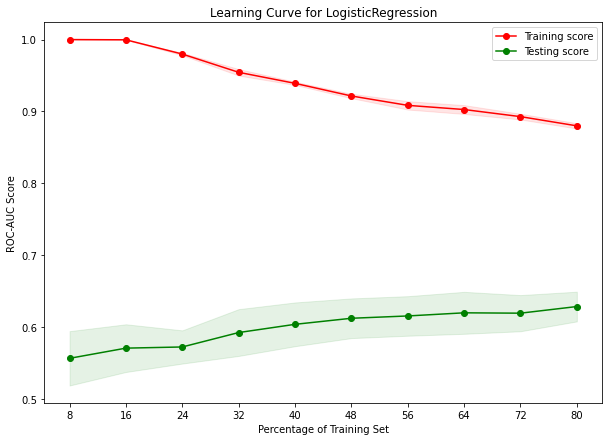

Average ROC-AUC for the train scores: 0.94
Average ROC-AUC for the test scores: 0.6


In [11]:
plot_learning_curve(LogisticRegression(class_weight='balanced'), scorer="roc_auc", oversampling=False, X=X_scaled, y=y, cv=5, n_jobs=-1)

##### Test 1: Histogram-Based Gradient Boosting

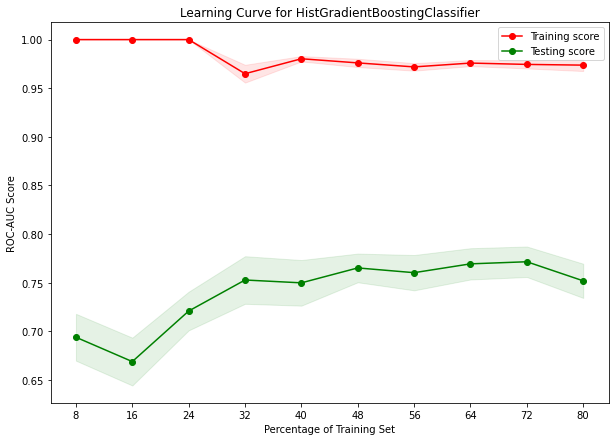

Average ROC-AUC for the train scores: 0.98
Average ROC-AUC for the test scores: 0.74


In [12]:
plot_learning_curve(HistGradientBoostingClassifier(), scorer="roc_auc", oversampling=False, X=X_scaled, y=y, cv=5, n_jobs=-1)

##### Test 1: Extreme Gradient Boosting

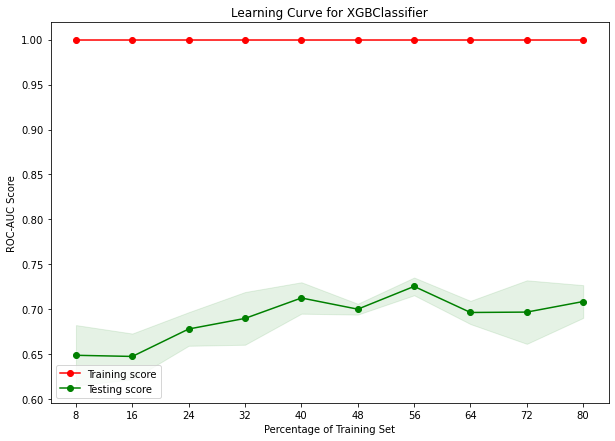

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.69


In [13]:
# calculate the a weight for the minority class
count_class_0 = float(len(y[y == 0]))
count_class_1 = float(len(y[y == 1]))
scale_pos_weight_val = count_class_0 / count_class_1

plot_learning_curve(xgb.XGBClassifier(use_label_encoder=False, 
                                      eval_metric='logloss', 
                                      scale_pos_weight=scale_pos_weight_val), 
                    scorer="roc_auc", oversampling=False, X=X_scaled, y=y, cv=5, n_jobs=-1)

### Test 2: Learning Curve for the whole dataset with the previous segmented PCA

In [14]:
# create X and y variables
X = train_df.drop(["RESPONSE"], axis=1)
y = train_df["RESPONSE"]

# Scale X using the previous scaler
loaded_scaler = load('models\\population_scaler.joblib')
X_scaled = loaded_scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# PCA using the segmented approach from the previous part
person_cols = load('models\\person_cols.joblib')
hh_cols = load('models\\hh_cols.joblib')
microcell_cols = load('models\\microcell_cols.joblib')
PLZ8_cols = load('models\\PLZ8_cols.joblib')
rest_cols = load('models\\rest_cols.joblib')

loaded_pca_person = load('models\\population_pca_person.joblib')
loaded_pca_hh = load('models\\population_pca_hh.joblib')
loaded_pca_microcell = load('models\\population_pca_microcell.joblib')
loaded_pca_PLZ8 = load('models\\population_pca_PLZ8.joblib')
loaded_pca_rest = load('models\\population_pca_rest.joblib')

pca_person_array = loaded_pca_person.transform(X_scaled[person_cols])
pca_hh_array = loaded_pca_hh.transform(X_scaled[hh_cols])
pca_microcell_array = loaded_pca_microcell.transform(X_scaled[microcell_cols])
pca_PLZ8_array = loaded_pca_PLZ8.transform(X_scaled[PLZ8_cols])
pca_rest_array = loaded_pca_rest.transform(X_scaled[rest_cols])

X_scaled_pca = np.hstack((pca_person_array, pca_hh_array, pca_microcell_array, pca_PLZ8_array, pca_rest_array))

# Add the previous clusters to the data and scale the clusters as well
loaded_clusterer = load('models\\population_clusterer.joblib')
clusters = loaded_clusterer.predict(X_scaled_pca)

X_scaled_pca = np.hstack((X_scaled_pca, clusters.reshape(-1, 1)))

##### Test 2: Logistic Regression

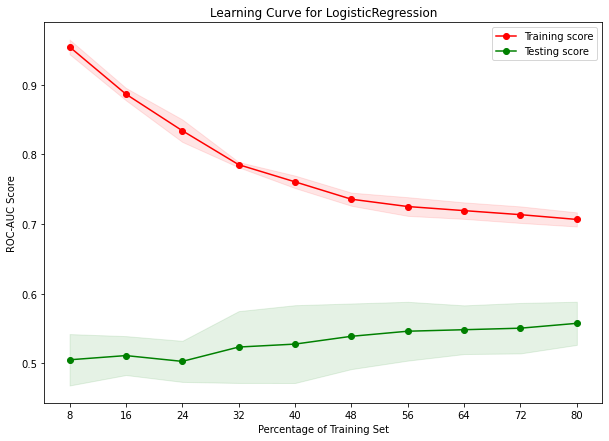

Average ROC-AUC for the train scores: 0.78
Average ROC-AUC for the test scores: 0.53


In [15]:
plot_learning_curve(LogisticRegression(class_weight='balanced'), scorer="roc_auc", oversampling=False, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

##### Test 2: Histogram-Based Gradient Boosting

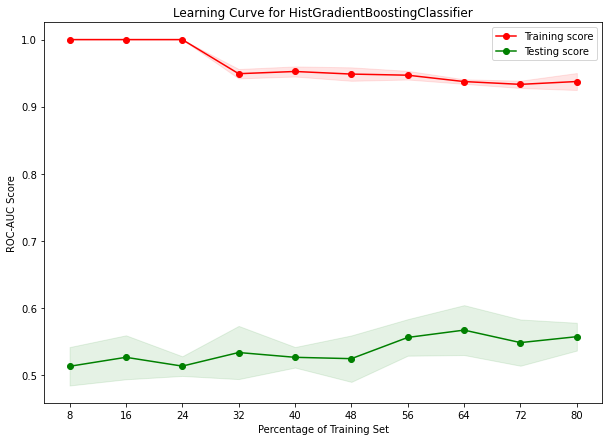

Average ROC-AUC for the train scores: 0.96
Average ROC-AUC for the test scores: 0.54


In [16]:
plot_learning_curve(HistGradientBoostingClassifier(), scorer="roc_auc", oversampling=False, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

##### Test 2: Extreme Gradient Boosting

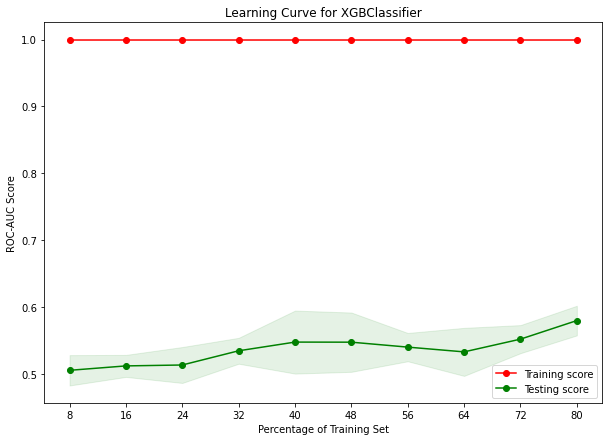

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.54


In [17]:
# calculate the a weight for the minority class
count_class_0 = float(len(y[y == 0]))
count_class_1 = float(len(y[y == 1]))
scale_pos_weight_val = count_class_0 / count_class_1

plot_learning_curve(xgb.XGBClassifier(use_label_encoder=False, 
                                      eval_metric='logloss', 
                                      scale_pos_weight=scale_pos_weight_val), 
                    scorer="roc_auc", oversampling=False,  X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

### Test 3: Learning Curve for the whole dataset with oversampling

##### Test 3: Logistic Regression

In [18]:
# create X and y variables
X = train_df.drop(["RESPONSE"], axis=1)
y = train_df["RESPONSE"]

# Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

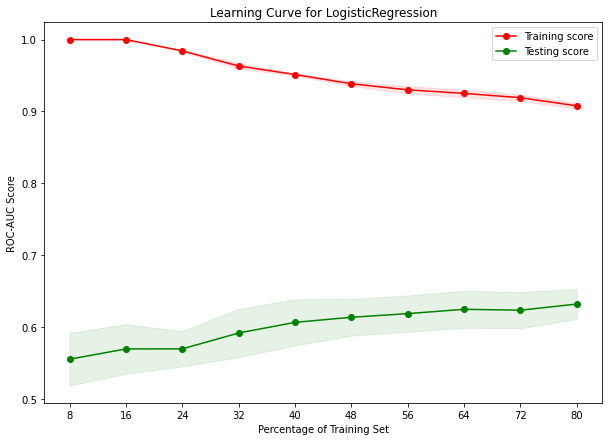

Average ROC-AUC for the train scores: 0.95
Average ROC-AUC for the test scores: 0.6


In [19]:
plot_learning_curve(LogisticRegression(max_iter=1000), scorer="roc_auc", oversampling=True, X=X_scaled, y=y, cv=5, n_jobs=-1)

##### Test 3: Histogram-Based Gradient Boosting

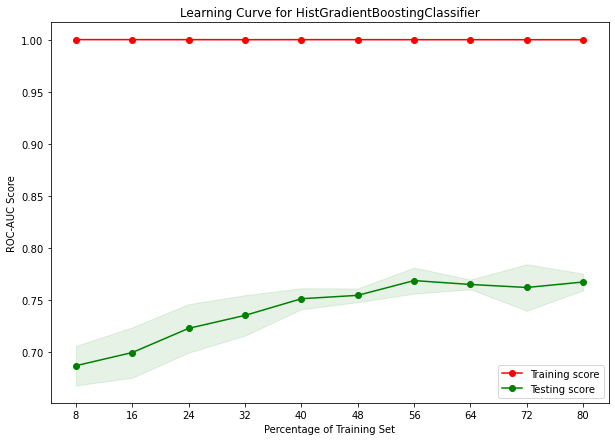

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.74


In [20]:
plot_learning_curve(HistGradientBoostingClassifier(), scorer="roc_auc", oversampling=True, X=X_scaled, y=y, cv=5, n_jobs=-1)

##### Test 3: Extreme Gradient Boosting

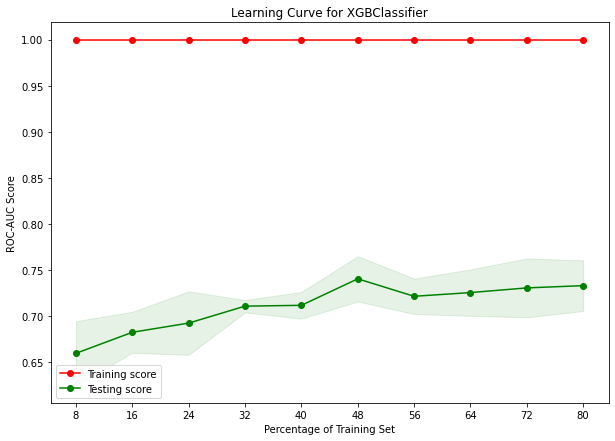

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.71


In [21]:
plot_learning_curve(xgb.XGBClassifier(use_label_encoder=False, 
                                      eval_metric='logloss'),
                    scorer="roc_auc", oversampling=True, X=X_scaled, y=y, cv=5, n_jobs=-1)

### Test 4: Learning Curve for the whole dataset with oversampling and with the previous segmented PCA

##### Test 4: Logistic Regression

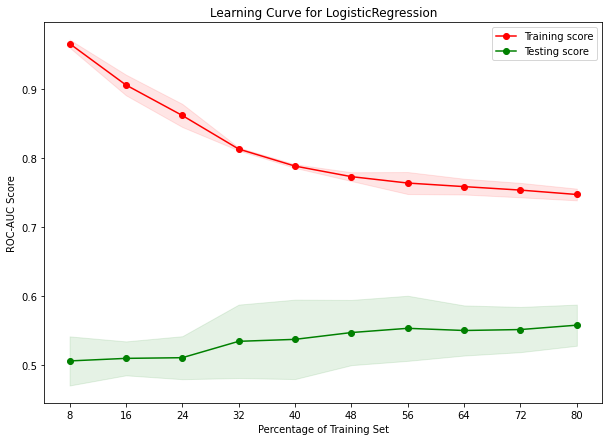

Average ROC-AUC for the train scores: 0.81
Average ROC-AUC for the test scores: 0.54


In [22]:
plot_learning_curve(LogisticRegression(max_iter=1000), scorer="roc_auc", oversampling=True, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

##### Test 4: Histogram-Based Gradient Boosting

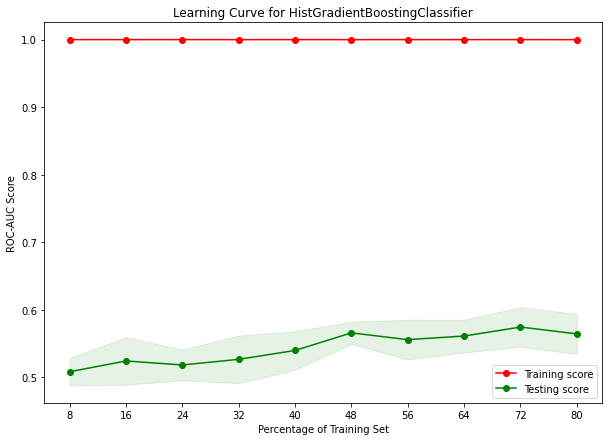

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.54


In [23]:
plot_learning_curve(HistGradientBoostingClassifier(), scorer="roc_auc", oversampling=True, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

##### Test 4: Extreme Gradient Boosting

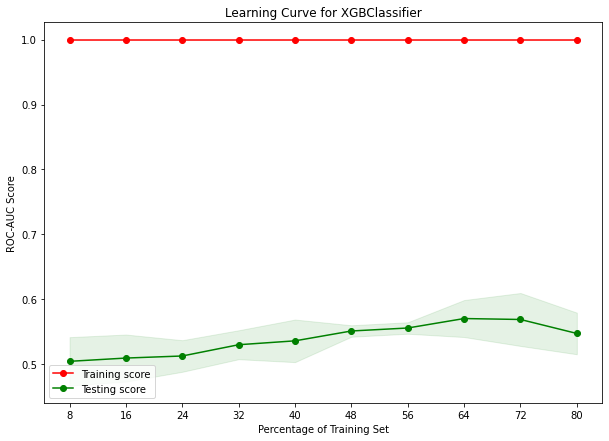

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.54


In [24]:
plot_learning_curve(xgb.XGBClassifier(use_label_encoder=False, 
                                      eval_metric='logloss'),
                    scorer="roc_auc", oversampling=True, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

### Test 5: Learning Curve for the whole dataset without and with a custom PCA
We will try and use a number of components that can explain 90% of the variance.

In [25]:
def plot_pca(df, column_list, df_name, threshold):
    """
    This function plots the cumulative explained variance using PCA for a particular threshold of explained variance. 
    It takes in as arguments a dataset, the list of columns, the name of the dataset and a threshold to find the number of components for that explained variance.
    """
    # Step 1: Select the data
    df = df[column_list]
    
    # Step 2: Fit a standard PCA to find the n components
    pca = PCA(random_state=101)
    pca_result = pca.fit_transform(df)

    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    n_components_for_threshold = np.where(cum_explained_variance >= threshold)[0][0]
    
    # Step 3 - Plot the Cumulative Explained Variances
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 2)
    plt.plot(range(len(explained_variance)), cum_explained_variance)
    plt.ylabel('Cumulative explained variance ratio')
    plt.xlabel('Number of components')
    plt.title(f'Cumulative Explained Variance Plot for the {df_name}')
    plt.axhline(y=threshold, color='grey', linestyle='--', label=f'Threshold at {threshold}') 

    plt.annotate(text = f"{n_components_for_threshold} components explain\n{round(threshold*100)}% of the variance.",
                 xy = (n_components_for_threshold, threshold),
                 xytext = (n_components_for_threshold, threshold-0.1),
                 arrowprops=dict(arrowstyle='->'))

    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show(); 

In [26]:
# create X and y variables
X = train_df.drop(["RESPONSE"], axis=1)
y = train_df["RESPONSE"]

# Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

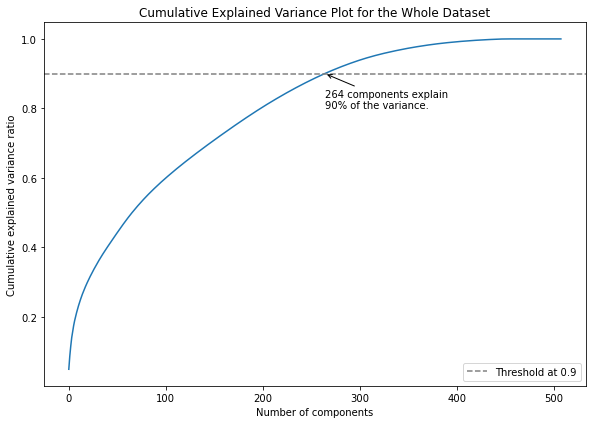

In [27]:
plot_pca(X_scaled, X.columns, "Whole Dataset", 0.90)

In [28]:
pca = PCA(n_components=264, random_state=101)
X_scaled_pca = pca.fit_transform(X_scaled)

##### Test 5: Logistic Regression

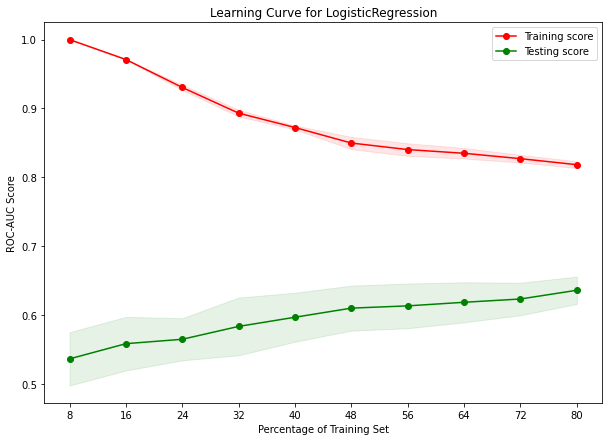

Average ROC-AUC for the train scores: 0.88
Average ROC-AUC for the test scores: 0.59


In [29]:
plot_learning_curve(LogisticRegression(class_weight='balanced'), scorer="roc_auc", oversampling=False, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

##### Test 5: Histogram-Based Gradient Boosting

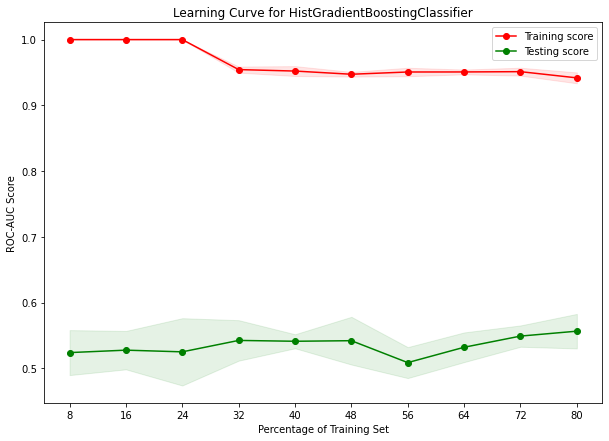

Average ROC-AUC for the train scores: 0.96
Average ROC-AUC for the test scores: 0.53


In [30]:
plot_learning_curve(HistGradientBoostingClassifier(), scorer="roc_auc", oversampling=False, X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

##### Test 5: Extreme Gradient Boosting

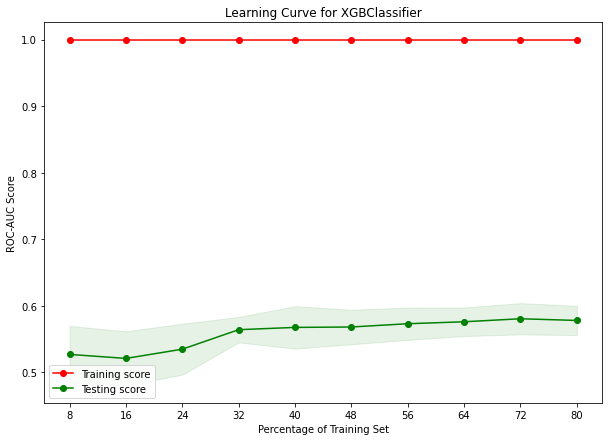

Average ROC-AUC for the train scores: 1.0
Average ROC-AUC for the test scores: 0.56


In [31]:
# calculate the a weight for the minority class
count_class_0 = float(len(y[y == 0]))
count_class_1 = float(len(y[y == 1]))
scale_pos_weight_val = count_class_0 / count_class_1

plot_learning_curve(xgb.XGBClassifier(use_label_encoder=False, 
                                      eval_metric='logloss', 
                                      scale_pos_weight=scale_pos_weight_val), 
                    scorer="roc_auc", oversampling=False,  X=X_scaled_pca, y=y, cv=5, n_jobs=-1)

__Analysis__: The table bellow summarizes the results of the 5 tests:

| Test # | Algorithm                         | Train Scores | Test Scores |
|--------|-----------------------------------|--------------|-------------|
| 1      | Logistic Regression               | 0.94         | 0.6         |
| 1      | Histogram-Based Gradient Boosting | 0.98         | 0.74        |
| 1      | Extreme Gradient Boosting         | 1.0          | 0.69        |
| 2      | Logistic Regression               | 0.78         | 0.53        |
| 2      | Histogram-Based Gradient Boosting | 0.96         | 0.54        |
| 2      | Extreme Gradient Boosting         | 1.0          | 0.54        |
| 3      | Logistic Regression               | 0.95         | 0.6         |
| __3__    | __Histogram-Based Gradient Boosting__ | __1.0__          | __0.74__      |
| 3      | Extreme Gradient Boosting         | 1.0          | 0.71        |
| 4      | Logistic Regression               | 0.81         | 0.54        |
| 4      | Histogram-Based Gradient Boosting | 1.0          | 0.54        |
| 4      | Extreme Gradient Boosting         | 1.0          | 0.54        |
| 5      | Logistic Regression               | 0.88         | 0.59        |
| 5      | Histogram-Based Gradient Boosting | 0.96         | 0.53        |
| 5      | Extreme Gradient Boosting         | 1.0          | 0.56        |

Given the results above we can break down the analysis by algorithm:

__Logistic Regression:__

Test 1 and Test 3 are the best configurations, with Test 1 being slightly better in terms of test scores.
Tests involving PCA (2, 4, 5) seem to reduce the performance for Logistic Regression.

__Histogram-Based Gradient Boosting:__

Test 1 and Test 3 are the best configurations, with both having similar test scores. However, the training score for Test 3 suggests potential overfitting.
Again, the PCA models (2, 4, 5) seem to have lower test performance, which indicates PCA might not be beneficial with this dataset for Gradient Boosting models.

__Extreme Gradient Boosting:__

Test 3 has the highest test score among the configurations.
The PCA models (especially Tests 2 and 4) show signs of overfitting, with a perfect training score but much lower test scores.


__Summary__:
- For Logistic Regression: Tests 1 and 3 are very similar.
- For Histogram-Based Gradient Boosting: Both Test 1 and Test 3 perform well.
- For Extreme Gradient Boosting: Test 3 is the best configuration.

__Decision__:

Test 3 with Histogram-Based Gradient Boosting stands out as the best combination:

- It achieved a test score of 0.74, which is among the highest of all test-algorithm combinations.
- While it has a training score of 1.0, indicating potential overfitting, this can be further managed and potentially reduced with hyperparameter tuning, regularization, and other techniques specific to Gradient Boosting models.

Given its performance in this preliminary assessment, I decided to proceed with for hyperparameter tuning and further model optimization with istogram-Based Gradient Boosting with the settings of Test 3.

# 4. Hyperparameter Tuning
We will use the HistGradientBoostingClassifier for this section with the data strategy of Test 3, using the whole dataset and oversampling for the lower class.

In [33]:
seed = 101

# create X and y variables
X = train_df.drop(["RESPONSE"], axis=1)
y = train_df["RESPONSE"]

# create the train, test and holdout splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_validation, X_holdout, y_validation, y_holdout = train_test_split(X_test, y_test, test_size=0.5, random_state=seed)

# Initialize the scaler based on the training data
scaler = StandardScaler().fit(X_train)

# Use the scaler to transform all your data splits
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_holdout_scaled = scaler.transform(X_holdout)

##### Hyperparameter Tunning for Histogram-Based Gradient Boosting

In [33]:
hgb = {
    "name": "Histogram-based Gradient Boosting",
    "model": HistGradientBoostingClassifier(),
    "param_distribution": {
        'max_iter': Integer(50, 1000), 
        'max_depth': Integer(3, 10),        
        'learning_rate': Real(0.01, 0.5, 'log-uniform'),  
        'l2_regularization': Real(0, 5),     
        'max_leaf_nodes': Integer(20, 255), 
        'random_state': Categorical([seed]) 
    } 
}

_First attempt, tuning for the best possible __F1__ score._

Training the model Histogram-based Gradient Boosting using BayesSearchCV...
Model: Histogram-based Gradient Boosting
Best Parameters: OrderedDict([('model__l2_regularization', 4.17360741633441), ('model__learning_rate', 0.041383066760454085), ('model__max_depth', 9), ('model__max_iter', 803), ('model__max_leaf_nodes', 74), ('model__random_state', 101)])
Overall Accuracy: 0.9870159981451426
Best F1-Score: 0.0273972602739726
----------------------------------------------------------------


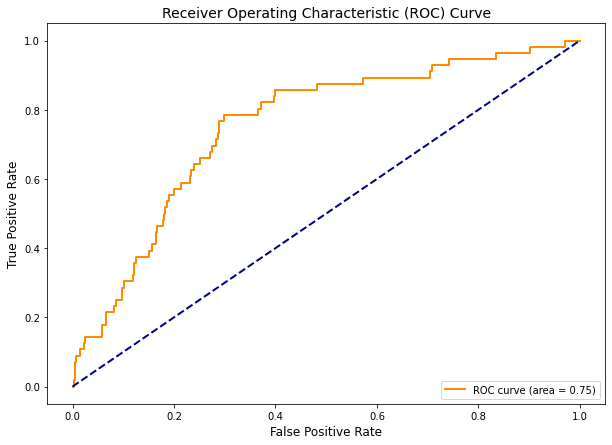

----------------------------------------------------------------


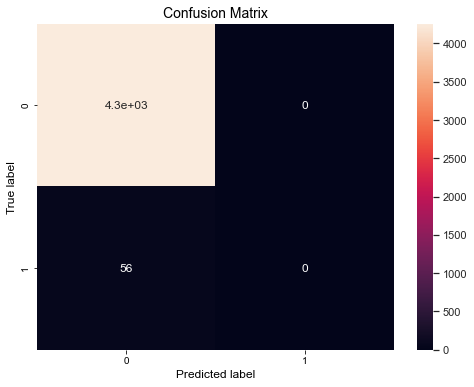

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4257
           1       0.00      0.00      0.00        56

    accuracy                           0.99      4313
   macro avg       0.49      0.50      0.50      4313
weighted avg       0.97      0.99      0.98      4313

----------------------------------------------------------------
Training time: 4:55:32.242914


In [34]:
best_model_hgb = predict_and_test_model(hgb, X_train_scaled, X_validation_scaled, y_train, y_validation, 5, "f1", seed, True)

_Second attempt, tuning for the best possible __Recall__ to see if it would be possible to find some of the true labels, even if at the cost of false-positives._

Training the model Histogram-based Gradient Boosting using BayesSearchCV...
Model: Histogram-based Gradient Boosting
Best Parameters: OrderedDict([('model__l2_regularization', 1.3657629728738927), ('model__learning_rate', 0.017381321583724997), ('model__max_depth', 10), ('model__max_iter', 998), ('model__max_leaf_nodes', 104), ('model__random_state', 101)])
Overall Accuracy: 0.9870159981451426
Best F1-Score: 0.030303030303030304
----------------------------------------------------------------


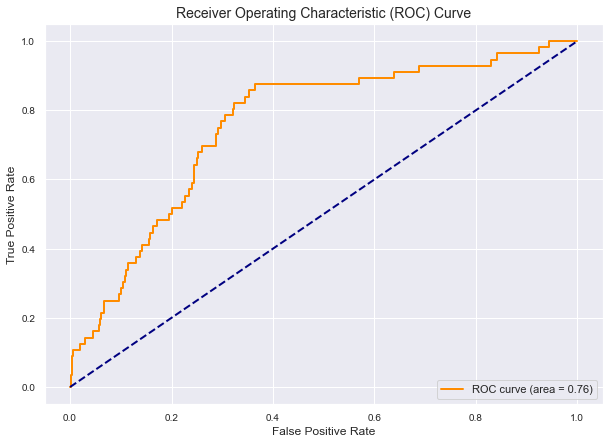

----------------------------------------------------------------


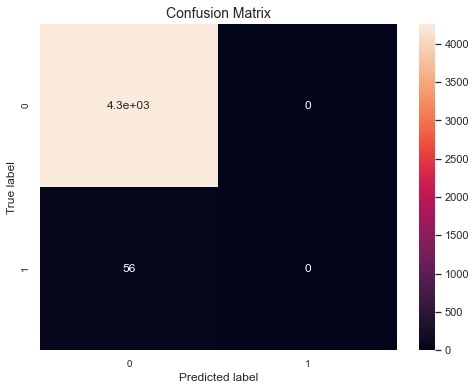

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4257
           1       0.00      0.00      0.00        56

    accuracy                           0.99      4313
   macro avg       0.49      0.50      0.50      4313
weighted avg       0.97      0.99      0.98      4313

----------------------------------------------------------------
Training time: 5:25:28.905087


In [35]:
best_model_hgb = predict_and_test_model(hgb, X_train_scaled, X_validation_scaled, y_train, y_validation, 5, "recall", seed, True)

##### Hyperparameter Tunning for BalancedRandomForestClassifier
I decided to try something I hadn't test before, namely use the model __BalancedRandomForestClassifier___ as it can natively handle imbalanced data. The idea was to tune the hyperparameters and refit to different metrics.

In [36]:
brf = {
    "name": "Balanced Random Forest",
    "model": BalancedRandomForestClassifier(n_jobs=-1),
    "param_distribution": {
        'n_estimators': Integer(50, 2500),   
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(3, 30),                   
        'min_samples_split': Integer(2, 20),              
        'min_samples_leaf': Integer(1, 20),               
        'max_features': Categorical(['sqrt', 'log2', None]),   
        'bootstrap': Categorical([True, False]),
        'class_weight' : Categorical(["balanced", "balanced_subsample", None]),
        'sampling_strategy': Categorical(["auto", "not minority", "not majority"]),
        'random_state': Categorical([seed]),
        'replacement': Categorical([True, False])        
    }
}

Training the model Balanced Random Forest using BayesSearchCV...
Model: Balanced Random Forest
Best Parameters: OrderedDict([('bootstrap', False), ('class_weight', 'balanced_subsample'), ('criterion', 'gini'), ('max_depth', 22), ('max_features', 'log2'), ('min_samples_leaf', 18), ('min_samples_split', 3), ('n_estimators', 772), ('random_state', 101), ('replacement', False), ('sampling_strategy', 'not majority')])
Overall Accuracy: 0.9870159981451426
Best F1-Score: 0.054794520547945216
----------------------------------------------------------------


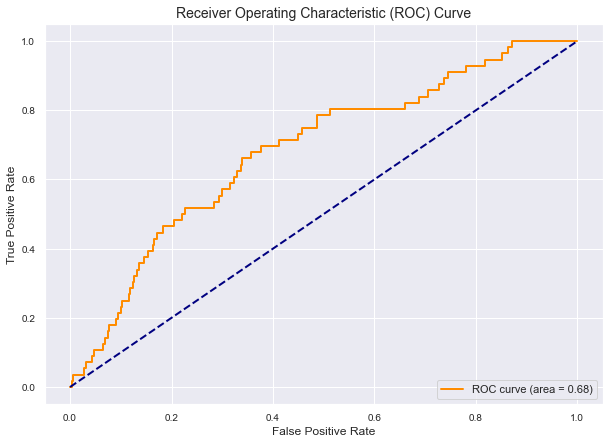

----------------------------------------------------------------


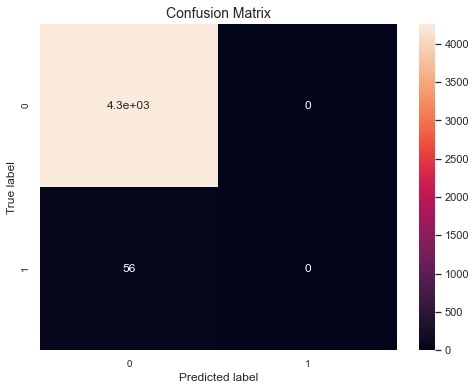

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4257
           1       0.00      0.00      0.00        56

    accuracy                           0.99      4313
   macro avg       0.49      0.50      0.50      4313
weighted avg       0.97      0.99      0.98      4313

----------------------------------------------------------------
Training time: 5:39:16.037775


In [37]:
# Refit with F1
best_model_brf = predict_and_test_model(brf, X_train_scaled, X_validation_scaled, y_train, y_validation, 5, "F1", seed, False)

Training the model Balanced Random Forest using BayesSearchCV...


C:\Users\bfernandes\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Model: Balanced Random Forest
Best Parameters: OrderedDict([('bootstrap', False), ('class_weight', None), ('criterion', 'entropy'), ('max_depth', 17), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 1299), ('random_state', 101), ('replacement', True), ('sampling_strategy', 'not majority')])
Overall Accuracy: 0.9870159981451426
Best F1-Score: 0
----------------------------------------------------------------


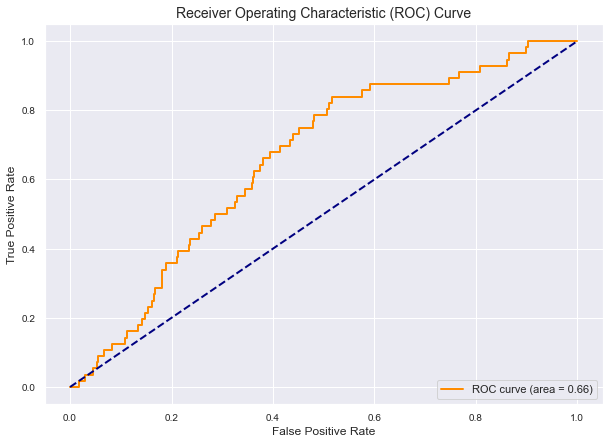

----------------------------------------------------------------


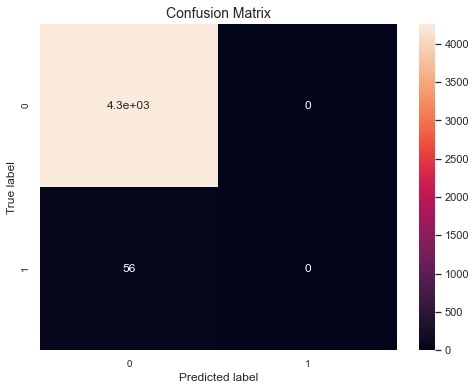

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4257
           1       0.00      0.00      0.00        56

    accuracy                           0.99      4313
   macro avg       0.49      0.50      0.50      4313
weighted avg       0.97      0.99      0.98      4313

----------------------------------------------------------------
Training time: 7:07:04.747687


In [38]:
# Refit with Precision
best_model_brf = predict_and_test_model(brf, X_train_scaled, X_validation_scaled, y_train, y_validation, 5, "Precision", seed, False)

##### Hyperparameter Tunning for LogisticRegression
Since none of the previous models was able to capture the slightest from the class 1, I decided to retry with logistic regression and see how it would performed after finding the best hyperparameter combination.

In [43]:
lr = {
    "name": "Logistic Regression",
    "model": LogisticRegression(n_jobs=-1),
    "param_distribution": {
        'max_iter': Integer(1, 2500),
        'penalty': Categorical(['l1', 'l2']),
        'C': Real(0.001, 10, 'log-uniform'),
        'fit_intercept': Categorical([True, False]),
        'solver': Categorical(['liblinear', 'saga']),
        'class_weight': Categorical([None, 'balanced']),
        'random_state': Categorical([seed])
    }
}

Training the model Logistic Regression using BayesSearchCV...


C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is 

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\l

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is 

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:122

Model: Logistic Regression
Best Parameters: OrderedDict([('C', 0.0037406577594324567), ('class_weight', None), ('fit_intercept', True), ('max_iter', 2016), ('penalty', 'l2'), ('random_state', 101), ('solver', 'liblinear')])
Overall Accuracy: 0.9870159981451426
Best F1-Score: 0
----------------------------------------------------------------


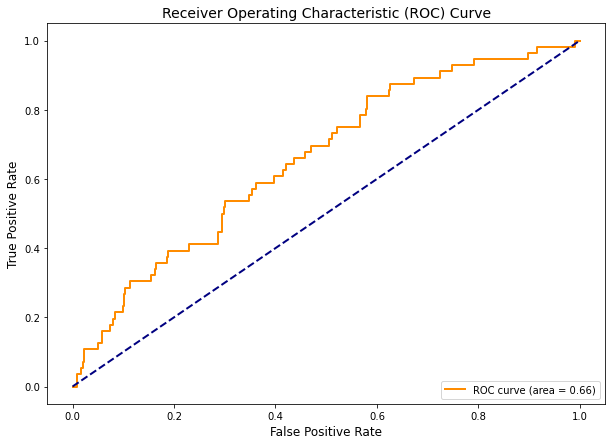

----------------------------------------------------------------


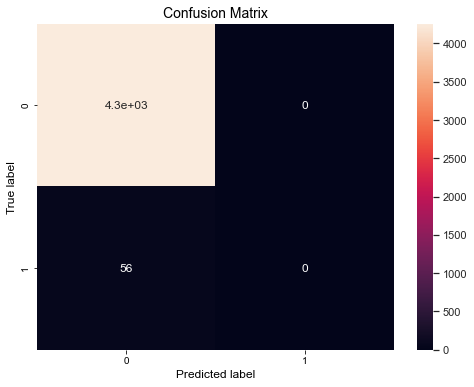

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4257
           1       0.00      0.00      0.00        56

    accuracy                           0.99      4313
   macro avg       0.49      0.50      0.50      4313
weighted avg       0.97      0.99      0.98      4313

----------------------------------------------------------------
Training time: 2:50:03.494266


In [44]:
# logistic Regression without oversampling
best_model_lr  = predict_and_test_model(lr, X_train_scaled, X_validation_scaled, y_train, y_validation, 5, "F1", seed, False)

Training the model Logistic Regression using BayesSearchCV...


C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is 

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:122

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is 

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: Con

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is 

C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1223: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
C:\Users\bfernandes\Anaconda3\lib\site-packages\sklearn\l

Model: Logistic Regression
Best Parameters: OrderedDict([('model__C', 0.11538870460680256), ('model__class_weight', 'balanced'), ('model__fit_intercept', True), ('model__max_iter', 242), ('model__penalty', 'l2'), ('model__random_state', 101), ('model__solver', 'saga')])
Overall Accuracy: 0.8022258288894041
Best F1-Score: 0.0736196319018405
----------------------------------------------------------------


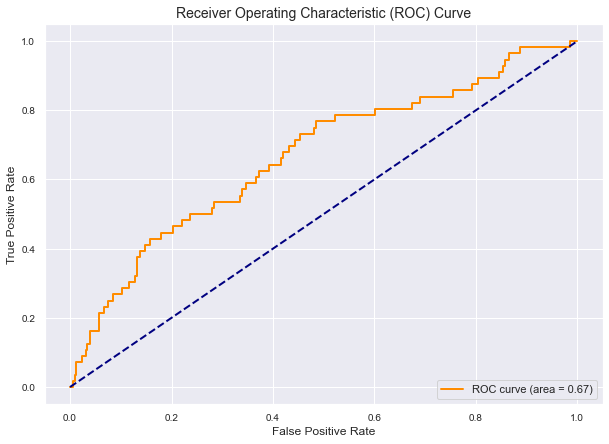

----------------------------------------------------------------


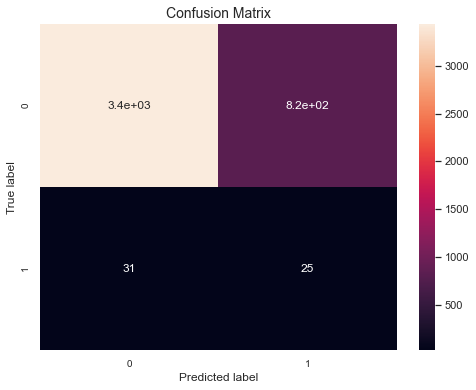

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      4257
           1       0.03      0.45      0.06        56

    accuracy                           0.80      4313
   macro avg       0.51      0.63      0.47      4313
weighted avg       0.98      0.80      0.88      4313

----------------------------------------------------------------
Training time: 6:43:15.475300


In [45]:
# logistic Regression with oversampling
best_model_lr  = predict_and_test_model(lr, X_train_scaled, X_validation_scaled, y_train, y_validation, 5, "F1", seed, True)

__analysis__: Although some approaches were taken to try and deal with the imbalanced label neither produced good results for the class 1. The models are clearly overfitting to the data and not learning the nuances. The next steps are merely representative just to finalize the normal CRISP process but the results ought to be ignored.

# 5. Model training & Evaluation
I picked the best model based on the ROC-AUC value.

In [48]:
# Combine training and validation datasets
X_combined = np.vstack((X_train_scaled, X_validation_scaled))
y_combined = np.hstack((y_train, y_validation))

# Train the final model
final_model = HistGradientBoostingClassifier(l2_regularization = 1.3657629728738927,
                                             learning_rate = 0.017381321583724997,
                                             max_depth = 10,
                                             max_iter = 998,
                                             max_leaf_nodes = 104, 
                                             random_state = 101)
final_model.fit(X_combined, y_combined)

HistGradientBoostingClassifier(l2_regularization=1.3657629728738927,
                               learning_rate=0.017381321583724997, max_depth=10,
                               max_iter=998, max_leaf_nodes=104,
                               random_state=101)

##### Performance Validation 

Estimator: HistGradientBoostingClassifier
Overall Accuracy: 0.987714418173389
F1-Score: 0.0
----------------------------------------------------------------


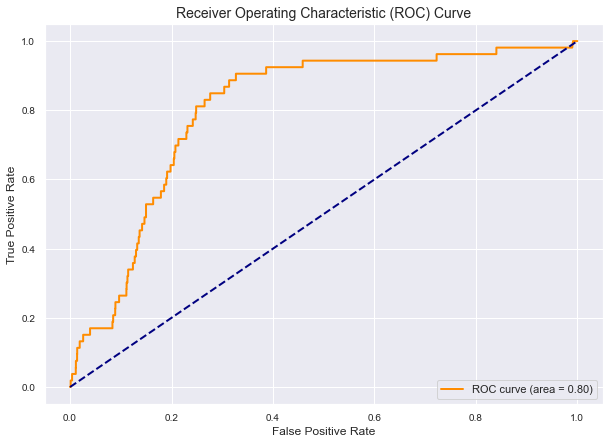

----------------------------------------------------------------


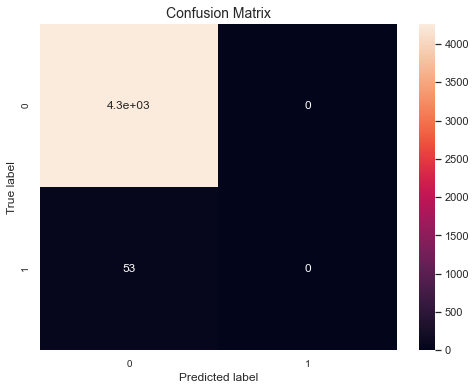

----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4261
           1       0.00      0.00      0.00        53

    accuracy                           0.99      4314
   macro avg       0.49      0.50      0.50      4314
weighted avg       0.98      0.99      0.98      4314

----------------------------------------------------------------


In [50]:
validate_best_model(final_model, X_holdout_scaled, y_holdout)

# 6. Predict on the new data

In [51]:
# scale test_df
scaled_test_df = scaler.transform(test_df)

# create predictions
preds = final_model.predict(scaled_test_df)

# Get indices where predictions are 0 or 1
zeros_indices = [i for i, pred in enumerate(preds) if pred == 0]
ones_indices = [i for i, pred in enumerate(preds) if pred == 1]

In [54]:
print(f"Out of {len(preds)} persons, {len(ones_indices)} ({round(len(ones_indices)/len(preds)*100)}%) would likely become customers.")

Out of 34499 persons, 0 (0%) would likely become customers.


# 7. Analysis of the results

As expected the model could not predict any customer and it is not suitable to be used. I've tried to find different approaches on how to deal with this data but none really worked well. At this stage it is difficult to see if there is anything wrong done during the processing of the data. I would need to invest more time in the data processing part, changing the strategy how to deal with the missing data and generate new features and see if this changes anything. It might also be that the data is simply not good enough for this task. Would this be a real-life scenario, I would have to discuss this s with the customer and ensure that we are indeed getting the correct labels. Also, if possible, gather more data.

If you are able to get this data and want to try out a different approach, here are some suggestions for a starting point:

- Make a more precise feature selection with the help of a domain expert, as some of the features may not have any importance or are redundant.
- Put more focus on feature engineering with the help of a domain expert to create more powerful features that add new relevant information to the dataset.
- See if you can deal with the missing data in a more precised way, for example using the median value of the same column or using other columns as reference.
- Try out different classification algorithms.
- Experiment in the prediction part like using alternative resampling techniques or including the threshold for the prediction in the deployment configuration. The latter could be achieved based on the predicted probability following this approach:
    1. Get the predicted probabilities for the positive class.
    2. Decide on a new threshold.
    3. Classify samples based on this new threshold.

# 8. Model Deployment

Since these models are not good, I am not goint to deploy them.